<a href="https://colab.research.google.com/github/butchland/fastai_nb_explorations/blob/master/ExploreKoryakinFingers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Exploration notebooks for Fingers datasets

## Environment setup

In [1]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   322  100   322    0     0    381      0 --:--:-- --:--:-- --:--:--   381
Updating fastai...
Done.


In [0]:
!pip install fastai2 --upgrade
!pip install fastcore --upgrade
!pip install nbdev --upgrade

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from fastai2.vision.all import *

In [0]:
escdrive = lambda x : x.as_posix().replace(' ','\ ')

In [0]:
gdrive = Path('/content/drive/My Drive/fastai_v4')

In [7]:
config = Config()
data_path = config.d['data_path']
archive_path = config.d['archive_path']
model_path = config.d['model_path']
(data_path, archive_path,model_path)

('/root/.fastai/data', '/root/.fastai/archive', '/root/.fastai/models')

## Prepare data

In [0]:
!ls {escdrive(gdrive/'data')}

ardamavi_Sign-Language-Digits-Dataset.tgz  mahendran1_fingers.zip
koryakinp_fingers.zip			   roshea6_finger-digits-05.zip


In [0]:
!mkdir -p {archive_path}
!cp {escdrive(gdrive/'data'/'koryakinp_fingers.zip')} {archive_path}

In [0]:
!ls {archive_path}/*

/root/.fastai/archive/koryakinp_fingers.zip


In [0]:
!unzip {archive_path}/koryakinp_fingers.zip

In [0]:
!ls -ald {archive_path}/*

-rw------- 1 root root 380836604 Apr  9 08:46 /root/.fastai/archive/koryakinp_fingers.zip


In [0]:
# clean extra copies and move data to data folder
!rm -rf train
!rm -rf test
!mv fingers data/koryakinp_fingers

## Explore data and folder structure

In [0]:
path = Path(data_path)/'koryakinp_fingers'

In [0]:
img_files = get_image_files(path)

In [0]:
img_files[:5]

(#5) [Path('/root/.fastai/data/koryakinp_fingers/train/66952cc5-8b4f-425b-b890-eaa5ad667a07_2L.png'),Path('/root/.fastai/data/koryakinp_fingers/train/3a97d203-0756-4039-9ae7-102136df2cff_2L.png'),Path('/root/.fastai/data/koryakinp_fingers/train/11b59162-454c-4664-83a5-f61ed7db920d_2R.png'),Path('/root/.fastai/data/koryakinp_fingers/train/cd7454b0-7953-45e6-b77e-aa7e343d9df5_5L.png'),Path('/root/.fastai/data/koryakinp_fingers/train/e93852ba-cb1c-4253-a851-f82686d05c6b_0R.png')]

In [0]:
len(img_files)

21600

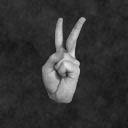

In [0]:
img1 = PILImage.create(img_files[0]);img1

In [0]:
img1.shape

(128, 128)

## Build datablock

In [0]:
pat = r'/[^/]+_([0-9RL]+).png$'
labeller = RegexLabeller(pat)

In [0]:
labeller(img_files[0])

'2L'

In [0]:
def is_valid(o):
  return parent_label(o) == 'test'

In [0]:
is_valid(img_files[0])

False

In [0]:
is_valid(Path(str(img_files[0]).replace('train','test')))

True

In [0]:
fing_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = labeller,
    splitter = FuncSplitter(is_valid),
    item_tfms = Resize(128)
)

In [0]:
fing_dblock.summary(path)

Setting-up type transforms pipelines
Found 21600 items
2 datasets of sizes 18000,3600
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/koryakinp_fingers/train/66952cc5-8b4f-425b-b890-eaa5ad667a07_2L.png
    applying PILBase.create gives
      PILImage mode=RGB size=128x128
  Pipeline: RegexLabeller -> Categorize
    starting from
      /root/.fastai/data/koryakinp_fingers/train/66952cc5-8b4f-425b-b890-eaa5ad667a07_2L.png
    applying RegexLabeller gives
      2L
    applying Categorize gives
      TensorCategory(4)

Final sample: (PILImage mode=RGB size=128x128, TensorCategory(4))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=128x1

## Build Datasets

In [0]:
fing_dsets = fing_dblock.datasets(path, verbose=True)

Found 21600 items
2 datasets of sizes 18000,3600
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize


In [0]:
list(fing_dsets.vocab)

['0L', '0R', '1L', '1R', '2L', '2R', '3L', '3R', '4L', '4R', '5L', '5R']

## Build DataFrames from Datasets

In [0]:
valid_df = pd.DataFrame({
    'inputs':pd.Series(fing_dsets.valid.items,dtype='object'),
    'labels':pd.Series([labeller(o) for o in fing_dsets.valid.items], dtype='category'),
    'split': pd.Series([parent_label(o) for o in fing_dsets.valid.items], dtype='category'),
})

In [0]:
train_df = pd.DataFrame({
    'inputs':pd.Series(fing_dsets.train.items,dtype='object'),
    'labels':pd.Series([labeller(o) for o in fing_dsets.train.items], dtype='category'),
    'split': pd.Series([parent_label(o) for o in fing_dsets.train.items], dtype='category'),
})

In [0]:
all_df = pd.concat([valid_df, train_df]); (all_df.head(), all_df.tail())

(                                                                                  inputs  ... split
 0  /root/.fastai/data/koryakinp_fingers/test/38837633-d6c8-4c7e-a748-6a08acad8919_5L.png  ...  test
 1  /root/.fastai/data/koryakinp_fingers/test/45505cf0-10c5-48b9-9ed5-9f2f0c2a9448_5R.png  ...  test
 2  /root/.fastai/data/koryakinp_fingers/test/0c95f57f-a1cb-4524-b573-d1ce377e9dac_2L.png  ...  test
 3  /root/.fastai/data/koryakinp_fingers/test/7cb7ad92-4dc5-4c3a-b136-a161f0f25148_5L.png  ...  test
 4  /root/.fastai/data/koryakinp_fingers/test/c1e3e52f-a5a6-4177-b9da-2a2224987074_3L.png  ...  test
 
 [5 rows x 3 columns],
                                                                                        inputs  ...  split
 17995  /root/.fastai/data/koryakinp_fingers/train/8364aacb-0644-4003-89c1-c8a9c84e75c0_2L.png  ...  train
 17996  /root/.fastai/data/koryakinp_fingers/train/0699409f-b41b-4d0f-a025-91ad0a532108_3R.png  ...  train
 17997  /root/.fastai/data/koryakinp_fingers/tra

In [0]:
valid_df['labels'].head()

0    5L
1    5R
2    2L
3    5L
4    3L
Name: labels, dtype: category
Categories (12, object): [0L, 0R, 1L, 1R, ..., 4L, 4R, 5L, 5R]

In [0]:
all_df.groupby(['split','labels']).count()

inputs
split labels        
test  0L         300
      0R         300
      1L         300
      1R         300
      2L         300
      2R         300
      3L         300
      3R         300
      4L         300
      4R         300
      5L         300
      5R         300
train 0L        1500
      0R        1500
      1L        1500
      1R        1500
      2L        1500
      2R        1500
      3L        1500
      3R        1500
      4L        1500
      4R        1500
      5L        1500
      5R        1500

## Build Dataloaders

In [0]:
# create new dblock with aug transforms
fing_dblock2 = fing_dblock.new(batch_tfms=aug_transforms(do_flip=False))

In [0]:
fing_dls = fing_dblock2.dataloaders(path)

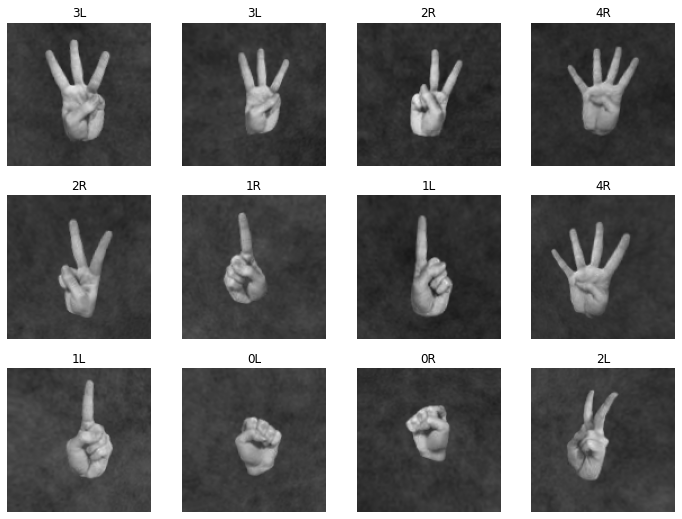

In [0]:
fing_dls.show_batch(max_n=12, nrows=3)

## Build Model

In [0]:
learn = cnn_learner(fing_dls, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.364161,0.161883,0.054722,01:03


epoch,train_loss,valid_loss,error_rate,time
0,0.050182,0.001905,0.000278,01:24
1,0.013748,0.000052,0.000000,01:23
2,0.001699,0.000078,0.000000,01:23
3,0.000693,0.000005,0.000000,01:23


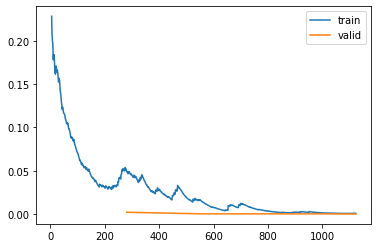

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.export()

In [0]:
learn.save('stage-1')

### Save Model and Clean Data to GDrive

In [0]:
!mkdir -p {escdrive(gdrive/'models'/'koryakinp_fingers')}

In [0]:
!cp models/stage-1.pth {escdrive(gdrive/'models'/'koryakinp_fingers')}
!cp export.pkl {escdrive(gdrive/'models'/'koryakinp_fingers')}

In [0]:
dataset ='koryakinp_fingers'
(dataset, data_path,path)

('koryakinp_fingers',
 '/root/.fastai/data',
 Path('/root/.fastai/data/koryakinp_fingers'))

In [0]:
!tar -czf {(Path(data_path)/(dataset + '.tgz')).as_posix()}  -C {Path(data_path).as_posix()} {path.as_posix()}  

tar: Removing leading `/' from member names


In [0]:
!cp data/koryakinp_fingers.tgz {escdrive(gdrive/'data')}